In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from keras.datasets import mnist

In [7]:
def Create_Generator():
    gen = tf.keras.Sequential()
    gen.add(tf.keras.layers.Dense(256, input_dim = 100))
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.Dense(512))
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.Dense(1024))
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.Dense(2048))
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.Dense(784, activation='sigmoid'))
    gen.compile(loss='binary_crossentropy', optimizer='Adam')
    return gen

In [8]:
def Create_Discriminator():
    dis = tf.keras.Sequential()
    dis.add(tf.keras.layers.Dense(2048, input_dim = 784))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    dis.add(tf.keras.layers.Dense(1024))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    dis.add(tf.keras.layers.Dense(512))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    dis.add(tf.keras.layers.Dense(256))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    dis.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    dis.compile(loss='binary_crossentropy', optimizer='Adam')
    return dis

In [9]:
def make_trainable(dis, flag):
    dis.trainable = flag
    for l in dis.layers:
        l.trainable = flag

In [10]:
def make_noise(n, z):
    return np.random.normal(0, 1, size=(n,z))

In [11]:
def plot_sample(n,z,Generator, index):
    print("Samples:")
    samples = Generator.predict(make_noise(n,z))
    plt.figure(figsize=(10,3))
    for i in range(n):
        plt.subplot(1,n, (i+1))
        plt.imshow(samples[i].reshape(28,28), cmap='gray_r')
        plt.axis('off')
    plt.savefig("Samples/MNIST_" + str(index) + "_Epochs_Examples",
               bbox_inches='tight',
               pad_inches = 0.5,
               transparent = False,
               dpi =400)
    plt.show()

In [12]:
def normalize(X):
    X = X.reshape(len(X), 784)
    X = X.astype('float32') / 255
    return X

In [13]:
def main():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
   
    X_train = normalize(X_train)
    
    Generator = Create_Generator()
    Discriminator = Create_Discriminator()
    
    
    np.random.seed(84)
    make_trainable(Discriminator, False)
    inputs = tf.keras.Input(shape=(100, ))
    fakes = Generator(inputs)
    output = Discriminator(fakes)
    Gan = tf.keras.Model(inputs,output)
    Gan.compile(loss='binary_crossentropy', optimizer='Adam')
    
    epochs = 100
    batch_size = 128
    input_dim = 100
    batch_no = int(len(X_train)/batch_size)
    Generator_Errors, Discriminator_Errors = (list(),list())
    
    for i in range(0, epochs):
        for j in range(batch_no):
            
            rand_sample = np.random.randint(0, len(X_train), size=batch_size)
            image_batch = X_train[rand_sample]
            
            input_noise = make_noise(batch_size, input_dim)
            generated_images = Generator.predict(input_noise)
            X = np.concatenate((image_batch,generated_images))
            
            Y = np.concatenate([[0.9] * batch_size, [0.0] * batch_size])
            
            make_trainable(Discriminator, True)
            Discriminator_Loss = Discriminator.train_on_batch(X,Y)
            make_trainable(Discriminator, False)
            
            input_noise = make_noise(batch_size, input_dim)
            fake_img = np.ones(batch_size)
            for _ in range(4):
                Generator_Loss = Gan.train_on_batch(input_noise, fake_img)

        Generator_Errors.append(Generator_Loss)
        Discriminator_Errors.append(Discriminator_Loss)
        
        if i % 10 == 0:
            print("Epoch %i" % i)
            plot_sample(20, input_dim, Generator, i)
    
    plt.figure(figsize=(15, 5))
    plt.plot(Discriminator_Errors, label='discriminitive loss')
    plt.plot(Generator_Errors, label='generative loss')
    plt.legend()
    plt.show()

2022-09-28 23:47:12.520082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-28 23:47:12.520125: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-28 23:47:12.520141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (145eae5ef469): /proc/driver/nvidia/version does not exist
2022-09-28 23:47:12.520369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 4ms/step
Epoch 0
Samples:
1/1 [==============================] - 0s 80ms/step


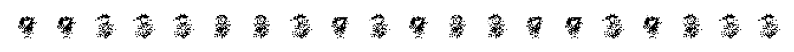

4/4 [==============================] - 0s 4ms/step


In [ ]:
if __name__ == '__main__':
    main()